# Graph neural network - CaMML course

CC-BY, blog by **[Timothée Jamin](jamint@bio.aau.dk)** and **[Ahmed Ismail](uccaais@ucl.ac.uk)**

# Introduction: How Graphs Are Helping Us Understand Materials Better



Materials science is all about understanding how atoms come together to form solids—and how these atomic arrangements give rise to useful properties like conductivity, magnetism, or chemical stability.

Thanks to machine learning, we now have powerful new tools to help answer that. One of the most exciting is called a Graph Neural Network (GNN).




![Comparison between GNN and Traditional](./pictures/Comparison.png)

Unlike traditional models that flatten this information into a vector (losing spatial relationships), GNNs preserve the structure and learn by passing messages between atoms. That means they can understand the material in a much deeper way—straight from its geometry and composition.

In this blog, we’ll explore how graph theory, GNNs, and convolutions are transforming how we model materials—and why this matters for science and technology.

# 📖 Graph Theory

To apply GNNs to materials, we first need to understand the graph theory that underpins the method. Graph theory provides the mathematical foundation for representing atomic structures.

In Materials science, a graph $G = (V,E)$, where $V$ is the set of nodes (or vertices) and $E$ the set of edges can be used to store information about the structure as follows:

Nodes (Vertices): Each atom in the material becomes a node in the graph. Node features may include atomic number, valence electrons, or electronegativity.

Edges (Links): Represent the connections between atoms—these can be direct chemical bonds or neighbors within a cutoff distance (e.g., $3.0$). Edge features may include bond length, bond type, or even directionality.

Graph: A complete material structure can then be modeled as a graph, where the spatial arrangement and types of atoms are preserved.

Adjacency Matrix: $A$ matrix $A$ of size $N \times N$ (where N is the number of atoms):

- $𝐴_{𝑖𝑗}$ = 1 if atoms $𝑖$ and $𝑗$ are connected within the cutoff,
- $𝐴_{𝑖𝑗}$ = 0 otherwise.

When we use convolution (filter) on these graphs, like in a Crystal Graph Convolutional Neural Networks (CGCNN), we are trying to help the model learn how each atom is influenced by its neighbors.

CGCNN applies the convolution operation to capture both local and global features from the crystal graph, helping predict properties like formation energy.

![GNN_Convolution](./pictures/GNN.png)

The idea is simple: each atom gathers information from the atoms it's connected to. This is great because it helps the model understand how atoms interact locally. But if we do this gathering (this convolution) too many times, something happens: the atom starts getting information from too many other atoms, even ones far away. It’s like trying to understand your neighborhood by asking friends, then your friends’ friends, and so on. After a while, the information gets so mixed up that you lose the details about your own block.

This is what we mean when we say you lose the specificity of location. The atom’s original, unique position and role in the structure gets blurred.

So, while convolution helps capture patterns and relationships in a graph, doing it too much can make all atoms start to look the same. In materials science, that’s a problem because tiny local differences can mean very different material properties.

In short: Graph convolution helps atoms learn from their neighbors—but too much of it, and you lose what makes each atom special.

## 🧪 Visualizing Crystal Structures as Graphs for GNNs

The following example shows how to represent the atomic structure of bismuth ferrite (BiFeO₃) from a CIF file and converts it into a graph, where:

Nodes represent atoms (Bi, Fe, and O),

Edges represent atomic neighbors within a cutoff distance (4 Å),

We use pymatgen and ASE to parse and process the structure, and NetworkX and Matplotlib to draw the resulting graph. This graph preserves the local connectivity and atomic identities of the structure—exactly the kind of representation a GNN model like CGCNN would consume for property prediction.

/tmp/ipykernel_485448/3832322004.py:11: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  structure = parser.get_structures()[0]


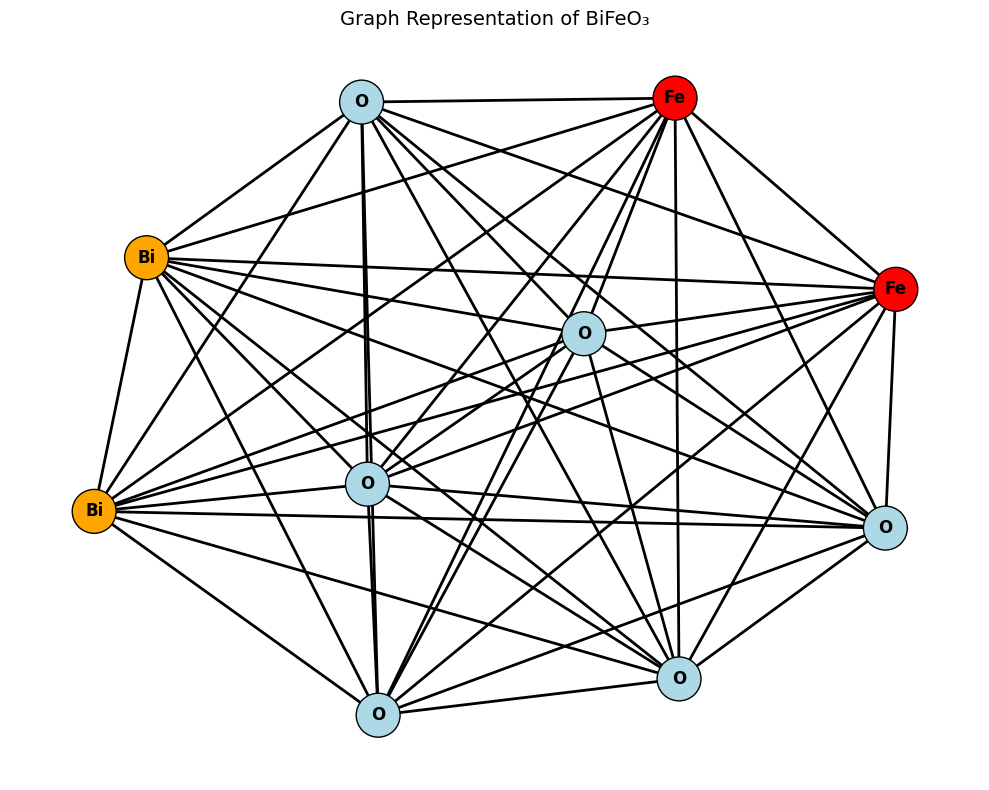

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import neighbor_list
import numpy as np
import torch

# Load BiFeO3 structure from CIF file
parser = CifParser("inputs/BiFeO3.cif")
structure = parser.get_structures()[0]

# Convert to ASE atoms object
atoms = AseAtomsAdaptor.get_atoms(structure)

# Define cutoff radius for neighbors
cutoff_radius = 4.0  # in Angstrom

# Generate edge list using ASE neighbor list
edge_src, edge_dst, edge_len = neighbor_list("ijd", atoms, cutoff=cutoff_radius, self_interaction=False)

color_map = {"Bi": "orange", "Fe": "red", "O": "lightblue"}

G = nx.Graph()
for i, site in enumerate(structure.sites):
    G.add_node(i, element=site.species_string) 

for s1, s2 in zip(edge_src, edge_dst):
    G.add_edge(s1, s2)

labels = {i: G.nodes[i]["element"] for i in G.nodes}
colors = [color_map[G.nodes[i]["element"]] for i in G.nodes]


pos = nx.spring_layout(G, seed=42)


plt.figure(figsize=(10, 8), facecolor='white') 
nx.draw_networkx_nodes(G, pos, node_color=colors, edgecolors='black', node_size=1000)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight="bold")
plt.title("Graph Representation of BiFeO₃", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In this blog, we explore how GNNs can predict the formation energy of materials—a key thermodynamic property that tells us how stable a structure is. Using data from the [Material Project](https://legacy.materialsproject.org/), we show how to convert real crystal structures into graphs, and how to train a GNN to predict energy from structure.

# 💻 How to program and code a GNN?

Thanks to this approach we can transform the theory into an useable algorithm.

To do so, we will take the time to build piece by piece our own GNN in this section. 

First of all, we need to have access to a sufficient amount of data to train our GNN. Here, the __[Material Project](https://legacy.materialsproject.org/)__ database will be used. Although we can train our GNN upon any property, we will only focus on the prediction of the formation energy of the solid using its structure and its composition.

The extraction and handling of the data will be similar to what is shown in the [matminer tutorial](https://github.com/hackingmaterials/matminer_examples/blob/main/matminer_examples/).

In [ ]:
# Here we will take some libraries to construct the neural-networks using torch.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Here are some diverse modules and functions necessary.
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# ASE and pymatgen modules
from ase import Atoms
from ase.neighborlist import neighbor_list
from pymatgen.io.ase import AseAtomsAdaptor

# matminer
# Be mindful that the MPDataRetrieval was here only tested for the old MP database!

from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

# Used for storing the datas. (Uses the method of Alex Ganose [a.ganose@imperial.ac.uk] for handling the datas)
import functools
from dataclasses import dataclass
from torch.utils.data import Dataset


## 💾 Data aquisition

In [4]:
# To ensure a reproducible results, we put the same random seed.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
mpdr = MPDataRetrieval("")

/home/lorentyfle/test/.venv/lib/python3.10/site-packages/pymatgen/ext/matproj.py:419: FutureWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  return _MPResterLegacy(*args, **kwargs)


In [8]:
# Can be long (~10min to grab all the necesary 126335 datas) if the material project legacy is here used.
df = mpdr.get_dataframe(criteria={}, properties=['formation_energy_per_atom', 'pretty_formula',"structure"])

100%|██████████| 126335/126335 [21:46<00:00, 96.66it/s] 


Now the database is ready, with only three columns needed to train our GNN upon:
 - The composition
 - The structure
 - The formation energy (the property we wish to predict)
 

In [9]:
df

formation_energy_per_atom pretty_formula  \
material_id                                             
mp-1001788                   -0.020860           ZrB6   
mp-1002206                    0.537123            SiC   
mp-1004524                    0.234287          HPbI3   
mp-1008492                   -0.349239           BrCl   
mp-1011260                   -2.517135         EuFeO3   
...                                ...            ...   
mvc-5634                     -2.022086      Ca2CuIrO6   
mvc-6019                     -1.619846      Zn(SnO2)2   
mvc-8011                     -1.584384      ZnFeAs2O7   
mvc-8692                     -2.438346    CaSb2(PO5)2   
mvc-9599                     -1.458839      Ca(CuO2)2   

                                                     structure  
material_id                                                     
mp-1001788   [[0. 0. 0.] Zr, [0.80207057 2.029387   2.02938...  
mp-1002206           [[0. 0. 0.] Si, [2.0251 2.0251 2.0251] C]  
mp-1004524   [[3.1221065 3.1221065 3.1221065] H, [0. 0. 0.]...  
mp-1008492   [[0. 0. 0.] Br, [0.        0.        3.9053505...  
mp-1011260   [[ 2.747224    2.72097164 -1.9501425 ] Eu, [5....  
...                                                        ...  
mvc-5634     [[3.15778709 8.03614231 5.77105139] Ca, [0.340...  
mvc-6019     [[ 0.         11.36829898  1.84505467] Zn, [0....  
mvc-8011     [[0.71270026 8.84632777 7.89206318] Zn, [5.112...  
mvc-8692     [[0.0143334 3.136694  4.121839 ] Ca, [5.866293...  
mvc-9599     [[0.30846523 0.         0.10485072] Ca, [9.270...  

[126335 rows x 3 columns]

If we then look at the distribution of the *formation energy per atom* as a function of the database, we have the histogram below.

[Text(0.5, 0, '$\\mathrm{E}_\\mathrm{f}/\\mathrm{atom}$'),
 Text(0, 0.5, 'Number of examples')]

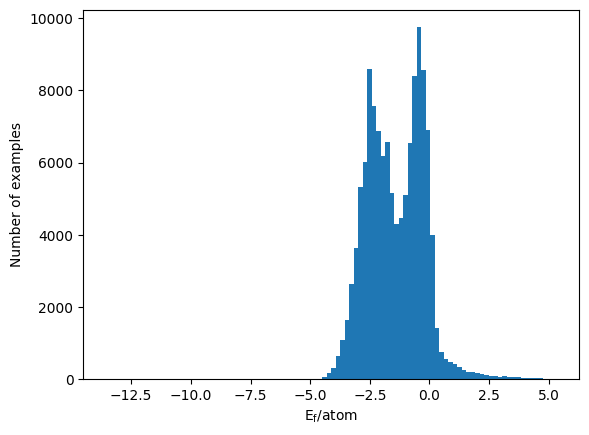

In [10]:
fig, ax = plt.subplots()
ax.hist(df["formation_energy_per_atom"], bins=100)
ax.set(xlabel="$\mathrm{E}_\mathrm{f}/\mathrm{atom}$", ylabel="Number of examples")

## 🔨 Transforming the data into a graph.

    Transforming a structure into a graph.

At last we have a curated database as a function of the target property, the formation energy.

Yet, we still lack a graph representation of the structure using nodes and edges. To do so, we can say that each atoms of each structures are a **node** and, their neigbhor the **edge**.

    Encoding information.

As the edge and the node are defined, one last step still remains before the data is ready. We need to encode some information inside the node and the edge to allow the machine learning to know the difference in between a Li next to an O and a I next to a Fe.


    Where can we encode the information?

Saving information inside the node seems very intuitive because we simply say that one node is one atom, such that the information of the atom type seems obvious.

As for the interactions, we can store this information inside the edges of the node; this is the **edge embedding**.

The simplest edge embedding would be the atomic connection; yet, we can also store further information like the bond length, the bond angle, etc...

Here we will be modest and only keep the atomic connection and the bond length as edge features.

### The Node: Encoding the nature of the atom

To encode the nature of the atom, one simple way would be to make an array of 118 entries (for each elements), then put a 1 where this atom is inside the periodic table of elements and all the other entries are zero.

This method called *one hot encoding* is here useful because it will reduce drastically the memory needed to identify the database while being really easy to read.

In [11]:
def one_hot_encode_z(atomic_number:int):
    """We return a onehot encoding of the periodic table of elements, inputting the Z number gives the good onehot encoding for the atom in question."""
    vector = np.zeros(118)
    vector[atomic_number-1] = 1
    return vector

In [12]:
node_features = torch.tensor(np.array([one_hot_encode_z(site.species.elements[0].Z) for site in df["structure"].iloc[0]]))
# Here our atom is Zr with Z=40, so we look at the 39th place to find it back.
print(node_features[0][39])
print(node_features[0])

tensor(1., dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


### The Edge: Keeping track of the atom connections.

Keeping track of the atom connection is not as hard as one may think. Indeed, we can simply use a prebuilt function inside [`ase`](https://wiki.fysik.dtu.dk/ase/) to output the list of neighboring connections and their length given a cutoff radius.

In [13]:
cutoff_radius = 4 # Angstrom

In [14]:
atoms = AseAtomsAdaptor.get_atoms(df["structure"].iloc[0])
edge_src, edge_dst, edge_len = neighbor_list(
                "ijd", atoms, cutoff=cutoff_radius, self_interaction=False
            )
# Cell parameter of atoms
atoms.cell

Cell([4.058774, 4.058774, 4.058774])

The three variables show the origin of the bond, its destination and the length.
In fact, it becomes evident that for such a crystal structure with cell parameters almost equal to $4$ Å, each of the atoms will be connected.

A simple approach to embbed the distances without having to create our own convolution would be to describe the edge feature as a weight on the node convolution.

One can take one node (black) connected to two other nodes (red and blue). 

![Edge_embedding](./pictures/edge_embedding.png)![Edge_embedding_wrong_weight](./pictures/edge_embedding_no_weight.png)

If no weight was involved then both of the red and blue nodes will have an equal involvment on the central node, which make this approximation inadequate.

![Edge_embedding_wrong_weight](./pictures/edge_embedding_with_weight.png)

If the convolution effect is decreased with the distance then it would reduce the amount of information given by far away atoms, which will add a small spatial contribution.


Thanks to a value of the distance that cannot excess a cutoff radius, then a normalisation of the distance followed by an inversion would be enough to create the weigths.

$$w_i = 1-\frac{d}{r_c}$$

Where $w_i$ is the weight of the edge, $d$ is its length and $r_c$ is the cutoff radius of the edge (no edge can have a distance superior to this cutoff).

## 🧳 Storing the data

Once we did all of this, we can try to store all this information inside a Data class that will possess all the information of our database.

In [15]:
## Classes of datas (these classes show how the data will be stored).
@dataclass
class Data:
    """
    Class to contain graph attributes.

    N and M are the number of nodes and edges in the graph, respectively.

    Parameters
    ----------
    x : Tensor
        The node features as a (N, n_node_feats) Tensor.
    edge_len : Tensor
        The edge length as a (M, ) Tensor.
    edge_index:
        [0] The index of the central node for each edge.
        [1] The index of the destination node for each edge.
    y : Tensor
        The target property to learn.
    atoms : Atoms
        An ase atoms object.
    """

    x: torch.Tensor
    y: torch.Tensor
    edge_len: torch.Tensor
    edge_index: torch.LongTensor
    atoms: Atoms

@dataclass
class Batch:
    """
    Class to contain batched graph attributes.

    N and M are the number of nodes and edges across all batched graphs,
    respectively.

    G is the number of graphs in the batch.

    Parameters
    ----------
    node_feat : Tensor
        The node features as a (N, n_node_feats) Tensor.
    edge_len : Tensor
        The edge length as a (M, ) Tensor
    edge_src : LongTensor
        The index of the central node for each edge.
    edge_dst : LongTensor
        The index of the destination node for each edge.
    edge_index:
        [0] The index of the central node for each edge.
        [1] The index of the destination node for each edge.
    y : Tensor
        The target property to learn, as a (G, 1) Tensor.
    batch : LongTensor
        The graph to which each node belongs, as a (N, ) Tensor.
    """

    x: torch.Tensor
    y: torch.Tensor
    edge_len: torch.Tensor
    edge_src: torch.LongTensor
    edge_dst: torch.LongTensor
    edge_index: torch.LongTensor
    batch: torch.LongTensor

    def to(self, device, non_blocking=False):
        for k, v in self.__dict__.items():
            self.__dict__[k] = v.to(device=device, non_blocking=non_blocking)

# First we take the data and store it inside a MaterialsDataSet (function created by Alex Ganose [a.ganose@imperial.ac.uk], adapted for this application.)

class MaterialsDataset_MP(Dataset):
    def __init__(self, df:pd.DataFrame, target_column:str, cutoff:float=4):
        """
        A dataset of materials properties extracted from Material Project.

        Parameters
        ----------
        df : pd.DataFrame
            DataFrame from Material Project.
        target_column : str
            Column of df used as the target. 
        cutoff : float
            The cutoff radius for searching for neighbors.
        """

        self.dataframe      = df
        self.data           = {i: {} for i in range(df.shape[0])}
        self.target_column  = target_column
        self.cutoff         = cutoff
        #
        for entry in range(self.dataframe.shape[0]):
            atoms = AseAtomsAdaptor.get_atoms(self.dataframe["structure"].iloc[entry])
            edge_src, edge_dst, edge_len = neighbor_list(
                "ijd", atoms, cutoff=self.cutoff, self_interaction=False
            )
            self.data[entry].update(
                {
                    "atoms": atoms,
                    "edge_src": edge_src,
                    "edge_dst": edge_dst,
                    "edge_len": edge_len,
                }
            )

    def __len__(self):
        return len(self.data)

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        entry = self.data[idx]

        # one hot encode element type
        node_feat = torch.Tensor([one_hot_encode_z(el) for el in entry["atoms"].get_atomic_numbers()])

        # Setup edge_distance to weight the edges.
        edge_distance=torch.tensor(1.0 - np.array(entry["edge_len"])/self.cutoff,dtype=torch.float32) # 

        return Data(
            x=torch.Tensor(node_feat),
            y=torch.Tensor([ self.dataframe[self.target_column].iloc[idx] ]),
            edge_len=torch.Tensor(edge_distance),
            edge_index=torch.Tensor(np.array([entry["edge_src"],entry["edge_dst"]])),
            atoms=entry["atoms"],
        )


# Then we use the collate_fn for creating the batches (function created by Alex Ganose [a.ganose@imperial.ac.uk], adapted for this application.)
def collate_fn(dataset):
    """
    Collate a list of Data objects and return a Batch.

    Parameters
    ----------

    dataset : MaterialsDataset_MP
        The dataset to batch.

    Returns
    -------
    Batch
        A batched dataset.
    """
    batch = Batch([], [], [], [], [], [], [])
    base_idx = 0
    for i, data in enumerate(dataset):
        batch.x.append(data.x)
        batch.y.append(data.y)
        batch.edge_len.append(data.edge_len)
        #
        batch.edge_index.append(data.edge_index + base_idx)
        batch.edge_src.append(data.edge_index[0] + base_idx)
        batch.edge_dst.append(data.edge_index[1] + base_idx)
        batch.batch.extend([i] * len(data.x))
        base_idx += len(data.x)
    return Batch(
        x=torch.cat(batch.x),
        y=torch.stack(batch.y),
        edge_len=torch.cat(batch.edge_len),
        edge_src=torch.cat(batch.edge_src).to(torch.long),
        edge_dst=torch.cat(batch.edge_dst).to(torch.long),
        edge_index=torch.LongTensor(np.array([torch.cat(batch.edge_src),torch.cat(batch.edge_dst)],dtype=np.int64)),
        batch=torch.LongTensor(batch.batch),
    )

In [16]:
cutoff_radius = 4.0
sample_size   = 10000

sampled_df = df.sample(n=sample_size, random_state=SEED)

dataset = MaterialsDataset_MP(
    sampled_df,
    "formation_energy_per_atom",
    cutoff=cutoff_radius,  # cutoff radius for finding neighbours
)

Now that our database is created, we can start to split it up in between a **training set**, a **testing set** and a **validation set**.

 - The training set is the set of data that will be used for training the model.
 - The validation set is the set of data that will be used to help the training of the model by showing verifications on untrained data, giving a score to train once again.
 - The testing set is the set of data that will be used to know how well the model can predict on unseen datas.

In [17]:
BATCH_SIZE       = 32
sampling_factors = [0.8, 0.1, 0.1]

In [18]:
train_set, valid_set, test_set = random_split(dataset, sampling_factors)

print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(valid_set)}')
print(f'Number of testing examples: {len(test_set)}')

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True,
)

val_loader = DataLoader(
    valid_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

## Correct all the dtypes.
for batch in train_loader:
    batch.edge_index = batch.edge_index.to(torch.int64)
    batch.edge_src   = batch.edge_src.to(torch.int64)
    batch.edge_dst   = batch.edge_dst.to(torch.int64)
    batch.edge_len   = batch.edge_len.to(torch.float32)

for batch in val_loader:
    batch.edge_index = batch.edge_index.to(torch.int64)
    batch.edge_src   = batch.edge_src.to(torch.int64)
    batch.edge_dst   = batch.edge_dst.to(torch.int64)
    batch.edge_len   = batch.edge_len.to(torch.float32)

for batch in test_loader:
    batch.edge_index = batch.edge_index.to(torch.int64)
    batch.edge_src   = batch.edge_src.to(torch.int64)
    batch.edge_dst   = batch.edge_dst.to(torch.int64)
    batch.edge_len   = batch.edge_len.to(torch.float32)

Number of training examples: 8000
Number of validation examples: 1000
Number of testing examples: 1000


/tmp/ipykernel_485448/2958961760.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  node_feat = torch.Tensor([one_hot_encode_z(el) for el in entry["atoms"].get_atomic_numbers()])


Here the batches have two purposes, splitting the datas to increase the computational time and handeling multiple graphs simultaneously, thanks to the `collate_fn` that would flatten the data accordingly.

Here the **batch** property in the flattened database allows to keep track which graph each atom belongs to inside each batches.

## 🤖 Making the GNN

To construct the GNN, we can split the task into two parts:
 - GNN class
 - Training and evaluation function

### GNN class

Here, the data is in the form of a graph that can be processed.
Indeed, to make it go through a neural network we can think of three main steps that can be applied.
1) The Message.

> The message is the information passed from one node to another.

Here, the message that needs to be passed to the node $i$ is a vector of all the features surrounding said node, such as the neighboring node information and its edge information.

To improve the efficiency of our GNN and to train our model on the atom nature, we can embed our *one-hot* node encoding by representing it into a continuous vector space of lower dimension, using `nn.Linear`.

![Picture_node](./pictures/node_embedding.png)

2) The Pooling

> The pooling is the way the messages from all neighbors are combined.

As it was discussed in the first part, we can pool the messages by performing a convolution on the neigbhors and edges embeddings.
For the sake of simplicity, a built in convolution class will here be used `nn.conv.GraphConv` that will perform a graph convolution on the only the node features. To add a small amount of information from the edges, the convolution from neighboring nodes will be weighted by the distance as it was discussed previously.

3) The Update

> The update is how the node `i` is updated given the pooled message.

The results of the convolution will here update the node `i` vector of features with the information from its neighbors.
Yet, we are interested in a **graph level property** prediction—the **formation energy** of the structure.

To do so, another pooling will be done over all the nodes using `torch_scatter.scatter_mean`, following this formula:

$$\mathbf{u}_c = \sum_{i\in G} \frac{\mathbf{v}_{i}^{(T)}}{|G|}$$

Where $\mathbf{u}_c$ is the vector for final pooling of the nodes, $G$ is the number of atoms and $\mathbf{v}_{i}^{(T)}$ is the vector of features of the node $i$ after the convolution from the neigbhors.

Thanks to these three steps we have the vector that describes the graph of the structure.

The $\mathbf{u}_c$ vector can then update the GNN over the target property, the formation energy of the structure. It would only require the addition of a Multilayer Perceptron (MLP) readout using the `nn.Linear` class and a non-linear activation function like a softplus.
It can be written as the following formula:

$$E_{f_c} = \sigma \left( \mathbf{W}_{r} \mathbf{u}_{c} + \mathbf{b}_{r} \right)$$

Where $E_{f_c}$ is the readout of the MLP for the fully connected feature dimension $f_c$ across all structures, $\mathbf{W}_{r}$ is the weight matrix, $\mathbf{b}_{r}$ is the bias vector, and $\sigma$ the softplus function.

![Softplus](./pictures/softplus.png)

Since $E_{f_c}$ is in between 0 and 1, only using a linear transformation over all the fully connected feature vector would allow to obtain a scalar that is fitted by the formation energy.


The skeleton of the GNN created can be visualised below:

![Plan_full_GNN](./pictures/full_GNN_algorithm.png)

In [19]:
from torch_geometric.nn.conv import GraphConv
from utils import scatter_mean 
class GNN(torch.nn.Module):
    def __init__(self,
        node_feat_dim,
        node_hidden_dim=64,
        num_graph_conv_layers:int=3,
        fc_feat_dim:int=128,
        ):
        # Using the super() class we can then say that our own GNN class is an extension of the nn.Module, stating that we have a Neural Network.
        super(GNN, self).__init__()

        # dense layer to transform one-hot encoded node features to embedding
        self.embedding = nn.Linear(node_feat_dim, node_hidden_dim)

        # set up the convolutions of GraphConv
        convs = []
        for _ in range(num_graph_conv_layers):
            convs.append(GraphConv(node_hidden_dim, node_hidden_dim,aggr="mean")) 
        self.convs = nn.ModuleList(convs)

        # dense layer to turn final node embeddings to the crystal features
        self.conv_to_fc = nn.Sequential(
           nn.Linear(node_hidden_dim, fc_feat_dim), nn.Softplus()
        )

        # dense layer to get the final target value
        self.fc_out = nn.Linear(fc_feat_dim, 1)

    def forward(self, batch):
        """
        Predict the target property given a batch of data.

        Parameters
        ----------
        batch : Batch
            The data to pass through the network.
        """
        # get initial node embedding
        node_feat = self.embedding(batch.x) ## Here x is the one-hot encoding of the nodes

        # apply convolutions
        for conv_func in self.convs:
        #            # forward( x = node_features, edge_index, edge_weight:Optional) -> Tensor
            node_feat = conv_func(node_feat, batch.edge_index , batch.edge_len) # 

        # pool node vectors
        crys_feat = scatter_mean(node_feat, batch.batch, dim=0, dim_size=batch.batch.max() + 1)

        # pass pooled vector through Fully Connected layer with activation
        crys_feat = self.conv_to_fc(crys_feat)

        # pass crystal features through final fully-connected layer        
        return self.fc_out(crys_feat)

### Training and evaluation function

Now that the class for the model is done, we need to train and evaluate it, for the validation and the testing of the model.


To do so, the training and evaluation functions are created. Both of the functions are here using a criterion function to determine the losses and compute the Mean Absolute Error (MAE) using the `nn.L1loss()` function.

Here the loss measure the difference in between the predicted value and the actual target value, while the MAE measures the average magnitude of errors between the predicted and actual values.

Thanks to these tools of prediction, it would then be possible to identify the accuracy of a model during and after its training.

Furthermore, the training function will then **backpropagate** the losses to allow to compute the gradient of the losses as a function of the model's parameters, and propagate the losses backward through each layer of the network. Finally, these gradient losses will then be interpreted by a **Stochastic Gradient Descent** algorithm that will update the model parameters from the previous layers of the network accordingly.

In [20]:
def train(dataloader, model, optimizer, criterion):
    epoch_loss = 0
    epoch_mae = 0
    
    model.train()
    
    for i, batch in enumerate(dataloader):
        # move the data onto the GPU if available
        # compute output
        y_pred = model(batch)
        loss = criterion(y_pred, batch.y)
        mae = nn.L1Loss()(y_pred, batch.y)
        
        # compute gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update metrics
        epoch_loss += loss.item()
        epoch_mae += mae.item()
        
    return epoch_loss / len(dataloader), epoch_mae / len(dataloader)

def evaluate(dataloader, model, criterion):
    epoch_loss = 0
    epoch_mae = 0
    
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            
            # compute output
            y_pred = model(batch)
            loss = criterion(y_pred, batch.y)
            mae = nn.L1Loss()(y_pred, batch.y)
                   
            # update metrics
            epoch_loss += loss.item()
            epoch_mae += mae.item()
        
    return epoch_loss / len(dataloader), epoch_mae / len(dataloader)

### Run the GNN

In [22]:
# Instantiate the model
hidden_channels         = 64
num_graph_conv_layers   = 3
fc_feat_dim             = 128
max_epoch               = 60


in_node_features = dataset[0].x.size()[1]
model = GNN(in_node_features, hidden_channels,num_graph_conv_layers=num_graph_conv_layers,fc_feat_dim=fc_feat_dim)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # We use a basic Adam optimizer.
criterion = torch.nn.MSELoss()  # Use CrossEntropyLoss for classification tasks

start_time = time.time()
save_losses_train = []
save_losses_valid = []
save_mae_train = []
save_mae_valid = []
# Using the DataLoaders for training and validation
for epoch in range(0,max_epoch):
    train_loss,train_mae = train(train_loader,model,optimizer,criterion)
    val_loss,valid_mae = evaluate(val_loader,model,criterion)
    # Save validation and losses.
    save_losses_train.append(train_loss)
    save_losses_valid.append(val_loss)
    save_mae_train.append(train_mae)
    save_mae_valid.append(valid_mae)
    #
    epoch_time = time.time() - start_time
    print(f'Epoch: {epoch+1:02} | Train MAE: {train_mae:8.4f} | Valid MAE: {valid_mae:8.4f}'
         f' |   Elapsed time: {time.strftime("%M min %S s", time.gmtime(epoch_time))}')
# Test the model
test_loss,test_mae = evaluate(test_loader,model,criterion)
print(f'Test Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f}')

Epoch: 01 | Train MAE:   0.5562 | Valid MAE:   0.4870 |   Elapsed time: 00 min 07 s
Epoch: 02 | Train MAE:   0.4718 | Valid MAE:   0.4586 |   Elapsed time: 00 min 14 s
Epoch: 03 | Train MAE:   0.4668 | Valid MAE:   0.4604 |   Elapsed time: 00 min 21 s
Epoch: 04 | Train MAE:   0.4335 | Valid MAE:   0.4168 |   Elapsed time: 00 min 27 s
Epoch: 05 | Train MAE:   0.3991 | Valid MAE:   0.3978 |   Elapsed time: 00 min 34 s
Epoch: 06 | Train MAE:   0.3331 | Valid MAE:   0.2777 |   Elapsed time: 00 min 41 s
Epoch: 07 | Train MAE:   0.2835 | Valid MAE:   0.2694 |   Elapsed time: 00 min 48 s
Epoch: 08 | Train MAE:   0.2736 | Valid MAE:   0.3448 |   Elapsed time: 00 min 56 s
Epoch: 09 | Train MAE:   0.2615 | Valid MAE:   0.2808 |   Elapsed time: 01 min 03 s
Epoch: 10 | Train MAE:   0.2734 | Valid MAE:   0.2443 |   Elapsed time: 01 min 10 s
Epoch: 11 | Train MAE:   0.2626 | Valid MAE:   0.3196 |   Elapsed time: 01 min 16 s
Epoch: 12 | Train MAE:   0.2618 | Valid MAE:   0.2819 |   Elapsed time: 01 m

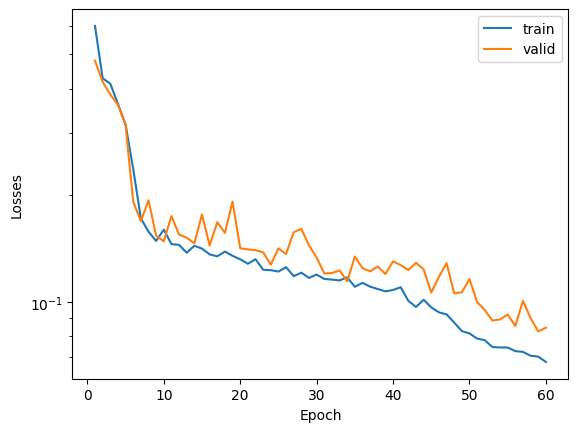

In [23]:
fig, ax = plt.subplots()
ax.plot(range(1,max_epoch+1), save_losses_train, label="train")
ax.plot(range(1,max_epoch+1), save_losses_valid, label="valid")
ax.set(xlabel="Epoch", ylabel="Losses")
ax.set_yscale("log")
plt.legend()

In [24]:
fig, ax = plt.subplots()
ax.plot(range(1,max_epoch+1), save_mae_train, label="train")
ax.plot(range(1,max_epoch+1), save_mae_valid, label="valid")
ax.set(xlabel="Epoch", ylabel="MAE")
ax.set_yscale("log")
plt.legend()

In [26]:
import matplotlib.pyplot as plt

actual = []
predicted = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        y_pred = model(batch)
        predicted.extend(y_pred.data.cpu().tolist())
        actual.extend(batch.y.tolist())
#
min_val, max_val = np.min(actual), np.max(actual)
#
fig, ax = plt.subplots()
ax.scatter(np.array(actual), np.array(predicted), label="test")
ax.plot([min_val, max_val], [min_val, max_val], color="orange", linestyle="--", label="actual")
ax.set(ylabel="Predicted E$_{f}$", xlabel="Actual E$_{f}$")
plt.legend()

Here the GNN fits $E_f$ with a large error in between the prediction and the actual $E_f$ value. However, this result can be explained by the fact the model created is not that expressive, with no descriptor of the surroundings that could have been done using Gaussians embedding of the distances or a [Smooth Overlap of Atomic Positions (SOAP)](https://doi.org/10.1103/PhysRevB.87.184115) descriptor for example. Also, the amount of data was too small for the diversity of different structures that can be found in material project legacy.

The construction of a simple GNN was indeed successful. However, we can easily see the limits of our approximations by taking such a diverse amount of datas. This shortcomings can be tackled by using a GNN that is more complex and that possesses more degrees of freedom, leading to Universal Machine Learning Force Fields such as NequIP, or MACE.

# 🔬 Chemical applications of GNNs

## MACE for Molecular Dynamic computation

One of the most well known examples of GNN is [MACE](https://doi.org/10.48550/arXiv.2401.00096), a universal machine learning force field (uMLFF). Using some pretrained models, it would be possible to run a Molecular Dynamic (MD) computation of diverse systems.

This model uses material project database with DFT (PBE+U) structures (here we are using MACE-MP-0, but other databases are available as pretrained models).

One way to use this uMLFF would be the computation of an MD calculation using [pretrained MACE MP models (the tutorial was used as a basis for the code below)](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html). Using ase an example of MD is here shown with NaCl above its fusion temperature.

In [27]:
from mace.calculators import mace_mp
from ase import build
from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

macemp = mace_mp() # return the default medium ASE calculator equivalent to mace_mp(model="medium") in MACE < 0.3.10 and mace_mp(model="medium-mpa-0") in MACE >= 0.3.10
#macemp = mace_mp(model="large") # return a larger model
#macemp = mace_mp(model="https://tinyurl.com/y7uhwpje") # downlaod the model at the given url
#macemp = mace_mp(dispersion=True) # return a model with D3 dispersion correction
atoms = build.bulk('NaCl', crystalstructure='rocksalt', a=5.64)
atoms.calc = macemp

# Initialize velocities.
T_init = 1300  # Initial temperature in K
MaxwellBoltzmannDistribution(atoms, T_init * units.kB)

# Set up the Langevin dynamics engine for NVT ensemble.
dyn = Langevin(atoms, 0.5 * units.fs, T_init * units.kB, 0.001)
n_steps = 200 # Number of steps to run
dyn.run(n_steps)

/home/lorentyfle/test/.venv/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /home/lorentyfle/.cache/mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/lorentyfle/test/.venv/lib/python3.10/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.


/home/lorentyfle/test/.venv/lib/python3.10/site-packages/ase/md/md.py:53: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


True